In [175]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from inspect import signature
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from collections import defaultdict
from typing import Dict
from matplotlib import cm

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Setup

In [19]:
from load_data import load_data
mibig_metadata, mibig_pfam, mibig_cathdb, funfams, sbp, sbp_all_pfam, bios = load_data()

(851, 20)
(918, 166)
(1519, 17)
(96, 10)
(863, 29)
(1345, 100)


In [20]:
### Create training dataset
mibig_metadata['label'] = -1
mibig_metadata.loc[~mibig_metadata.Activities.isnull(), 'label'] = 0
mibig_metadata.loc[mibig_metadata.Siderophore == 1, 'label'] = 1
mibig_training = mibig_metadata[mibig_metadata['label'] >= 0][['BGC', 'Gram', 'label']]

In [21]:
siderophore_data = {}
siderophore_data['pfam_and_sbps'] = sbp_all_pfam.merge(mibig_training, on='BGC', how='inner')
siderophore_data['cathdbs'] = mibig_cathdb.merge(mibig_training, on='BGC', how='inner')
siderophore_data['biosynth'] = bios.merge(mibig_training, on='BGC', how='inner')

# Bar chart for PFAM

In [22]:
cols = siderophore_data['pfam_and_sbps'].columns.drop(['BGC', 'Gram', 'label'])
cols = cols[siderophore_data['pfam_and_sbps'][cols].sum() >= 3]

other_neg = siderophore_data['pfam_and_sbps'].query("Gram == 0 & label == 0")[cols]
siderophore_neg = siderophore_data['pfam_and_sbps'].query("Gram == 0 & label == 1")[cols]

other_plus = siderophore_data['pfam_and_sbps'].query("Gram == 1 & label == 0")[cols]
siderophore_plus = siderophore_data['pfam_and_sbps'].query("Gram == 1 & label == 1")[cols]


In [23]:
print(other_neg.shape)
print(siderophore_neg.shape)
print(other_plus.shape)
print(siderophore_plus.shape)

(42, 18)
(24, 18)
(142, 18)
(16, 18)


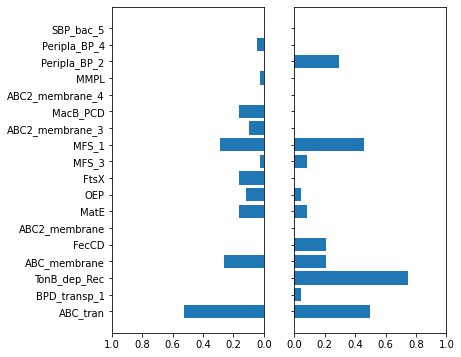

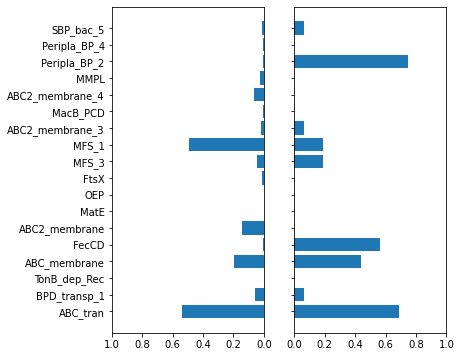

In [24]:
## Plot barchart

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams["figure.figsize"] = (6,6)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(other_neg.sum()[cols].keys(), other_neg.astype(bool).sum()[cols] / other_neg.shape[0], align='center')
axes[1].barh(siderophore_neg.sum()[cols].keys(), siderophore_neg.astype(bool).sum()[cols] / siderophore_neg.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)

axes[0].invert_xaxis()
plt.savefig("Fig3a1.svg")

plt.show()

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(other_plus.sum()[cols].keys(), other_plus.astype(bool).sum()[cols] / other_plus.shape[0], align='center')
axes[1].barh(siderophore_plus.sum()[cols].keys(), siderophore_plus.astype(bool).sum()[cols] / siderophore_plus.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)

axes[0].invert_xaxis()

plt.savefig("Fig3a2.svg")

plt.show()

# Statistical tests

In [233]:
import scipy.stats as stats

## Run fisher exact tests

pvalues1 = []
pvalues2 = []
for pfam in cols:
    compare1 = [siderophore_plus[pfam].sum(),other_plus[pfam].sum()]
    compare2 = [siderophore_plus[cols.drop(pfam)].sum().sum(), other_plus[cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues1.append(pvalue)
    
    compare1 = [siderophore_neg[pfam].sum(),other_neg[pfam].sum()]
    compare2 = [siderophore_neg[cols.drop(pfam)].sum().sum(), other_neg[cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues2.append(pvalue)
    
## Multiple correction
t1 = multipletests(np.array(pvalues1),alpha=0.05,method='fdr_bh')
t2 = multipletests(np.array(pvalues2),alpha=0.05,method='fdr_bh')

i = 0
for pfam in cols:
    compare = [siderophore_plus[pfam].astype(bool).sum(),other_plus[pfam].astype(bool).sum()]
    
    if t1[1][i] < 0.05:
        print(pfam)
        print("Pos Siderophore :" + str(int(compare[0] / siderophore_plus.shape[0] * 100)))
        print("Pos Other :" + str(int(compare[1] / other_plus.shape[0] * 100)))
        print(t1[1][i])
        
    compare = [siderophore_neg[pfam].astype(bool).sum(),other_neg[pfam].astype(bool).sum()]        
    if t2[1][i] < 0.05:
        print(pfam)
        print("Neg Siderophore :" + str(int(compare[0] / siderophore_neg.shape[0] * 100)))
        print("Neg Other :" + str(int(compare[1] / other_neg.shape[0] * 100)))
        print(t2[1][i])
    i += 1

TonB_dep_Rec
Neg Siderophore :75
Neg Other :0
1.0348607353309106e-06
FecCD
Pos Siderophore :56
Pos Other :0
1.9473873456035507e-11
FecCD
Neg Siderophore :20
Neg Other :0
0.0030426956525166694
ABC2_membrane
Pos Siderophore :0
Pos Other :14
0.04910456851032214
MatE
Neg Siderophore :8
Neg Other :16
0.026450391293041314
FtsX
Neg Siderophore :0
Neg Other :16
0.040644860220260884
MFS_1
Pos Siderophore :18
Pos Other :49
4.878801215427109e-06
ABC2_membrane_3
Neg Siderophore :0
Neg Other :9
0.028518932268444125
MacB_PCD
Neg Siderophore :0
Neg Other :16
0.040644860220260884
Peripla_BP_2
Pos Siderophore :75
Pos Other :0
2.4616097479535855e-07
Peripla_BP_2
Neg Siderophore :29
Neg Other :0
0.023849492810602443


# Bar charts and stats for CATHDBs

In [399]:
cathdb_cols = siderophore_data['cathdbs'].columns.drop(['BGC', 'Gram', 'label'])

cathdb_siderophore_plus = siderophore_data['cathdbs'].query("Gram == 1 & label == 1")[cathdb_cols]
cathdb_other_plus = siderophore_data['cathdbs'].query("Gram == 1 & label == 0")[cathdb_cols]
cathdb_siderophore_neg = siderophore_data['cathdbs'].query("Gram == 0 & label == 1")[cathdb_cols]
cathdb_other_neg = siderophore_data['cathdbs'].query("Gram == 0 & label == 0")[cathdb_cols]

In [400]:
## counts
print(cathdb_siderophore_plus.shape[0])
print(cathdb_other_plus.shape[0])
print(cathdb_siderophore_neg.shape[0])
print(cathdb_other_neg.shape[0])

16
146
23
43


In [407]:
pvalues1 = []
pvalues2 = []
for pfam in cathdb_cols:
    compare1 = [cathdb_siderophore_plus[pfam].sum(),cathdb_other_plus[pfam].sum()]
    compare2 = [cathdb_siderophore_plus[cathdb_cols.drop(pfam)].sum().sum(), cathdb_other_plus[cathdb_cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues1.append(pvalue)
    
    compare1 = [cathdb_siderophore_neg[pfam].sum(),cathdb_other_neg[pfam].sum()]
    compare2 = [cathdb_siderophore_neg[cathdb_cols.drop(pfam)].sum().sum(), cathdb_other_neg[cathdb_cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues2.append(pvalue)
    
## Multiple correction
t1 = multipletests(np.array(pvalues1),alpha=0.05,method='fdr_bh')
t2 = multipletests(np.array(pvalues2),alpha=0.05,method='fdr_bh')


sig_pos = set()
sig_neg = set()
i = 0
for pfam in cathdb_cols:
    compare = [cathdb_siderophore_plus[pfam].astype(bool).sum(),cathdb_other_plus[pfam].astype(bool).sum()]
    
    if t1[1][i] < 0.05:
        print(pfam)
        print("Pos Siderophore :" + str(int(compare[0] / cathdb_siderophore_plus.shape[0] * 100)))
        print("Pos Siderophore :" + str(int(compare[1] / cathdb_other_plus.shape[0] * 100)))
        print(t1[1][i])
        sig_pos.add(pfam)
    compare = [cathdb_siderophore_neg[pfam].astype(bool).sum(),cathdb_other_neg[pfam].astype(bool).sum()]        
    if t2[1][i] < 0.05:
        sig_neg.add(pfam)
        print(pfam)
        print("Neg Siderophore :" + str(int(compare[0] / cathdb_siderophore_neg.shape[0] * 100)))
        print("Neg Siderophore :" + str(int(compare[1] / cathdb_other_neg.shape[0] * 100)))
        print(t2[1][i])
    i += 1

1.10.3470.10/FF/21766
Pos Siderophore :56
Pos Siderophore :0
2.8077379004975227e-11
1.20.1250.20/FF/180940
Pos Siderophore :12
Pos Siderophore :39
0.003976968210812274
3.40.50.300/FF/628304
Neg Siderophore :0
Neg Siderophore :18
0.04709297391534748
2.170.130.10/FF/21034
Neg Siderophore :78
Neg Siderophore :0
0.0022080909071473492
2.40.170.20/FF/26209
Neg Siderophore :65
Neg Siderophore :0
0.009009321995915906
3.40.50.1980/FF/29572
Pos Siderophore :75
Pos Siderophore :0
6.532808443332168e-07


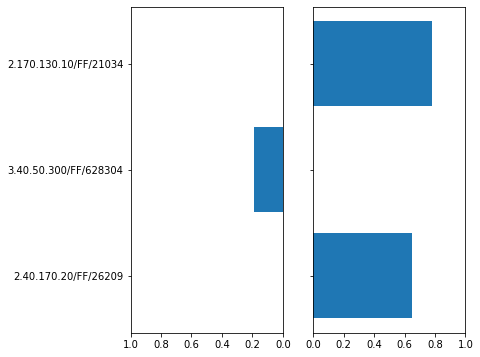

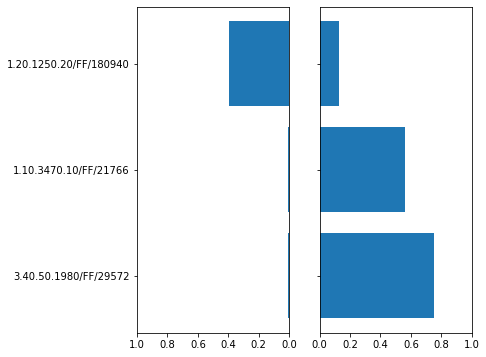

In [408]:
## Plot barchart

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams["figure.figsize"] = (6,6)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(cathdb_other_neg.sum()[sig_neg].keys(), cathdb_other_neg.astype(bool).sum()[sig_neg] / cathdb_other_neg.shape[0], align='center')
axes[1].barh(cathdb_siderophore_neg.sum()[sig_neg].keys(), cathdb_siderophore_neg.astype(bool).sum()[sig_neg] / cathdb_siderophore_neg.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
axes[0].invert_xaxis()
plt.savefig("FigS1-1.svg")

plt.show()

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(cathdb_other_plus.sum()[sig_pos].keys(), cathdb_other_plus.astype(bool).sum()[sig_pos] / cathdb_other_plus.shape[0], align='center')
axes[1].barh(cathdb_siderophore_plus.sum()[sig_pos].keys(), cathdb_siderophore_plus.astype(bool).sum()[sig_pos] / cathdb_siderophore_plus.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
axes[0].invert_xaxis()

plt.savefig("FigS1-2.svg")

plt.show()

# Bar charts and tests for Biosynthetic

In [403]:
bios_cols = siderophore_data['biosynth'].columns.drop(['BGC', 'Gram', 'label'])

bios_siderophore_plus = siderophore_data['biosynth'].query("Gram == 1 & label == 1")[bios_cols]
bios_other_plus = siderophore_data['biosynth'].query("Gram == 1 & label == 0")[bios_cols]
bios_siderophore_neg = siderophore_data['biosynth'].query("Gram == 0 & label == 1")[bios_cols]
bios_other_neg = siderophore_data['biosynth'].query("Gram == 0 & label == 0")[bios_cols]

In [404]:
## counts
print(bios_siderophore_plus.shape[0])
print(bios_other_plus.shape[0])
print(bios_siderophore_neg.shape[0])
print(bios_other_neg.shape[0])

23
184
27
84


In [409]:
pvalues1 = []
pvalues2 = []
for pfam in bios_cols:
    compare1 = [bios_siderophore_plus[pfam].sum(),bios_other_plus[pfam].sum()]
    compare2 = [bios_siderophore_plus[bios_cols.drop(pfam)].sum().sum(), bios_other_plus[bios_cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues1.append(pvalue)
    
    compare1 = [bios_siderophore_neg[pfam].sum(),bios_other_neg[pfam].sum()]
    compare2 = [bios_siderophore_neg[bios_cols.drop(pfam)].sum().sum(), bios_other_neg[bios_cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues2.append(pvalue)
    
## Multiple correction
t1 = multipletests(np.array(pvalues1),alpha=0.05,method='fdr_bh')
t2 = multipletests(np.array(pvalues2),alpha=0.05,method='fdr_bh')


sig_neg = set()
sig_pos = set()
i = 0
for pfam in bios_cols:
    compare = [bios_siderophore_plus[pfam].astype(bool).sum(),bios_other_plus[pfam].astype(bool).sum()]
    
    if t1[1][i] < 0.05:
        print(pfam)
        print("Pos Abx :" + str(int(compare[0] / bios_siderophore_plus.shape[0] * 100)))
        print("Pos Other :" + str(int(compare[1] / bios_other_plus.shape[0] * 100)))
        print(t1[1][i])
        sig_pos.add(pfam)
    compare = [bios_siderophore_neg[pfam].astype(bool).sum(),bios_other_neg[pfam].astype(bool).sum()]        
    if t2[1][i] < 0.05:
        sig_neg.add(pfam)
        print(pfam)
        print("Neg Abx :" + str(int(compare[0] / bios_siderophore_neg.shape[0] * 100)))
        print("Neg Other :" + str(int(compare[1] / bios_other_neg.shape[0] * 100)))
        print(t2[1][i])
    i += 1

ACPS
Neg Abx :29
Neg Other :7
0.0001663066409796991
Acyl_transf_1
Pos Abx :4
Pos Other :37
1.2355843390989215e-07
Acyl_transf_1
Neg Abx :11
Neg Other :44
0.030344726655517247
Aldedh
Neg Abx :11
Neg Other :1
0.030344726655517247
AMP-binding
Pos Abx :82
Pos Other :56
1.3369477502309512e-14
Condensation
Pos Abx :78
Pos Other :29
5.487757075623886e-22
Condensation
Neg Abx :55
Neg Other :66
0.0006738222654488914
Esterase
Pos Abx :13
Pos Other :0
0.0028719330873149753
GFO_IDH_MocA
Neg Abx :11
Neg Other :0
0.009906214440441433
IucA_IucC
Pos Abx :21
Pos Other :0
1.523454577671577e-10
IucA_IucC
Neg Abx :29
Neg Other :0
1.0404123517243108e-15
ketoacyl-synt
Pos Abx :4
Pos Other :49
9.798807977135909e-11
ketoacyl-synt
Neg Abx :11
Neg Other :54
2.567970847394249e-06
Ketoacyl-synt_C
Pos Abx :4
Pos Other :50
1.152278751235527e-10
Ketoacyl-synt_C
Neg Abx :11
Neg Other :54
2.567970847394249e-06
KR
Pos Abx :17
Pos Other :28
0.007566005739555961
KR
Neg Abx :11
Neg Other :48
0.0011217500169572348
p450
Pos

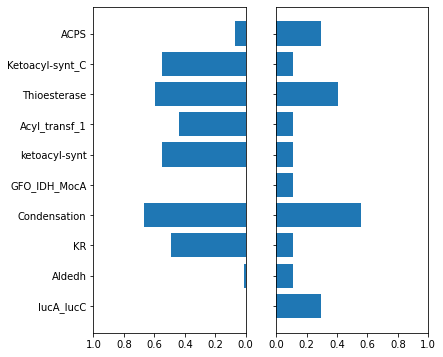

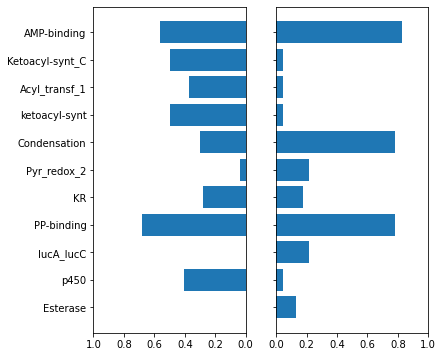

In [410]:
## Plot barchart

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams["figure.figsize"] = (6,6)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(bios_other_neg.sum()[sig_neg].keys(), bios_other_neg.astype(bool).sum()[sig_neg] / bios_other_neg.shape[0], align='center')
axes[1].barh(bios_siderophore_neg.sum()[sig_neg].keys(), bios_siderophore_neg.astype(bool).sum()[sig_neg] / bios_siderophore_neg.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
axes[0].invert_xaxis()
plt.savefig("FigS1-3.svg")

plt.show()

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(bios_other_plus.sum()[sig_pos].keys(), bios_other_plus.astype(bool).sum()[sig_pos] / bios_other_plus.shape[0], align='center')
axes[1].barh(bios_siderophore_plus.sum()[sig_pos].keys(), bios_siderophore_plus.astype(bool).sum()[sig_pos] / bios_siderophore_plus.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
axes[0].invert_xaxis()

plt.savefig("FigS1-4.svg")

plt.show()

# Classifier functions

In [414]:
def plot_pr_curves(precisions, recalls, names, task, cmap_name="tab20"):
    cm = plt.get_cmap(cmap_name)

    _recalls = recalls
    _precisions = precisions
    cgen = [cm(1. * i/len(_recalls)) for i in range(len(_recalls))]

    plt.figure(figsize=(5, 5))
    for color, precision, recall, key in zip(cgen, _precisions, _recalls, names):
        step_kwargs = ({'step': 'post'}
                      if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, alpha=0.8, color=color, linewidth=5, linestyle='-',
                 where='post', label=key)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
    plt.legend()
    plt.savefig("pr_curve_siderophore2.svg")
    plt.show()

In [392]:
## Classifier
from sklearn.preprocessing import StandardScaler

def fit_classifier(data, clf_type):
    if clf_type == 'lasso':
        clf = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga', class_weight='balanced', max_iter=1000)
    elif clf_type == 'tree':
        clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3)

    X = data[data.columns.drop(['BGC', 'label', 'Gram'])]

    y = data['label']
    
    n_split = 5
    n_repeats = 5
    
    ## metrics
    precisions = []
    recalls = []
    accuracies = []
    auprcs = []
    
    ## cross validation
    coefs = []
    for i in range(n_repeats):
        kf = StratifiedKFold(n_splits=n_split)
        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
            y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            #save scores
            precisions.append(precision_score(y_test, preds, zero_division=0))
            recalls.append(recall_score(y_test, preds))
            accuracies.append(accuracy_score(y_test, preds))
            auprcs.append(average_precision_score(y_test, preds))
            if clf_type == 'lasso':
                coef = clf.coef_.ravel()
                coefs.append(coef)
    ## calculate medians and range
    cv_precision = np.mean(precisions)
    cv_recall = np.mean(recalls)
    cv_accuracy = np.mean(accuracies)
    cv_aupcr = np.mean(auprcs)

    ## Now run on entire dataset
    scaler = StandardScaler()
    X_orig = X
    X = pd.DataFrame(scaler.fit_transform(X))
    clf.fit(X, y)
    preds = clf.predict_proba(X)
    precisions, recalls, _ = precision_recall_curve(y, preds[:, 1])
    auprc = average_precision_score(y, preds[:, 1])
    variables = []
    dfs = []
    # get features if it's a lasso 
    if clf_type == 'lasso':
        coefs = np.array(coefs)
        results = pd.DataFrame(coefs)
        results = results.rename(columns={i: f for i, f in enumerate(X_orig.columns)})
        results = results.melt(var_name='feature', value_name='vals')
        dfs.append(results)
        dfs = pd.concat(dfs)
        dfs2 = dfs[dfs.vals > 0]
        dfs = dfs[dfs.feature.isin(dfs2.feature.unique())]
        dfs = dfs.sort_values('vals', ascending=False)
        
    fit = {"precisions": precisions, "recalls": recalls, "features": dfs, "auprc": auprc, "cv_precision": cv_precision, "cv_recall":cv_recall, "cv_accuracy": cv_accuracy, "cv_aupcr": cv_aupcr}
    return fit            

In [393]:
results = {}
combined = pd.merge(siderophore_data['pfam_and_sbps'], siderophore_data['biosynth'], on='BGC', how='right')
combined['Gram'] = combined.Gram_y
combined['label'] = combined.label_y
del combined['Gram_y']
del combined['Gram_x']
del combined['label_y']
del combined['label_x']
combined = combined.fillna(0)

results['pfam_1'] = fit_classifier(siderophore_data['pfam_and_sbps'].query("Gram == 1"), 'tree')
results['pfam_0'] = fit_classifier(siderophore_data['pfam_and_sbps'].query("Gram == 0"), 'tree')
results['cath_1'] = fit_classifier(siderophore_data['cathdbs'].query("Gram == 1"), 'tree')
results['cath_0'] = fit_classifier(siderophore_data['cathdbs'].query("Gram == 0"), 'tree')
results['bios_1'] = fit_classifier(siderophore_data['biosynth'].query("Gram == 1"), 'tree')
results['bios_0'] = fit_classifier(siderophore_data['biosynth'].query("Gram == 0"), 'tree')
results['combined_1'] = fit_classifier(combined.query("Gram == 1"), "tree")
results['combined_0'] = fit_classifier(combined.query("Gram == 0"), "tree")

results['pfam_1_l'] = fit_classifier(siderophore_data['pfam_and_sbps'].query("Gram == 1"), 'lasso')
results['pfam_0_l'] = fit_classifier(siderophore_data['pfam_and_sbps'].query("Gram == 0"), 'lasso')
results['cath_1_l'] = fit_classifier(siderophore_data['cathdbs'].query("Gram == 1"), 'lasso')
results['cath_0_l'] = fit_classifier(siderophore_data['cathdbs'].query("Gram == 0"), 'lasso')
results['bios_1_l'] = fit_classifier(siderophore_data['biosynth'].query("Gram == 1"), 'lasso')
results['bios_0_l'] = fit_classifier(siderophore_data['biosynth'].query("Gram == 0"), 'lasso')
results['combined_1_l'] = fit_classifier(combined.query("Gram == 1"), "lasso")
results['combined_0_l'] = fit_classifier(combined.query("Gram == 0"), "lasso")


In [394]:
results_table = defaultdict(list)
for r in results:
    results_table['Task'].append(r)
    results_table['Precision (Cross Validation)'].append(results[r]['cv_precision'])
    results_table['Recall (Cross Validation)'].append(results[r]['cv_recall'])
    results_table['Accuracy (Cross Validation)'].append(results[r]['cv_accuracy'])
    results_table['AUPRC Total'].append(results[r]['auprc'])
    results_table['AUPRC (Cross Validation)'].append(results[r]['cv_aupcr'])
    
pd.DataFrame(results_table)

,Task,Precision (Cross Validation),Recall (Cross Validation),Accuracy (Cross Validation),AUPRC Total,AUPRC (Cross Validation)
0,pfam_1,0.933333,0.750000,0.968347,0.818094,0.730757
1,pfam_0,1.000000,0.748000,0.911868,0.893939,0.836132
2,cath_1,0.900000,0.750000,0.962879,0.879089,0.707955
3,cath_0,0.970000,0.780000,0.914945,0.915020,0.837824
4,bios_1,0.258857,0.254000,0.886039,0.482097,0.264459
5,bios_0,0.714545,0.446667,0.763794,0.610884,0.402751
6,combined_1,0.750000,0.554000,0.944669,0.691009,0.566953
7,combined_0,0.950000,0.673333,0.909881,0.826781,0.724361
8,pfam_1_l,0.683333,0.750000,0.917137,0.858651,0.543257
9,pfam_0_l,1.000000,0.740000,0.908791,0.942157,0.831209


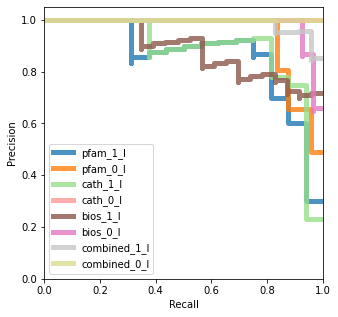

In [415]:
precisions = []
recalls = []
names = []
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

for r in results:
    if '_l' in r:
        names.append(r)
        precisions.append(results[r]['precisions'])
        recalls.append(results[r]['recalls'])
plot_pr_curves(precisions, recalls, names, "Siderophore")

precisions = []
recalls = []
names = []

for r in results:
    if '_l' not in r:
        names.append(r)
        precisions.append(results[r]['precisions'])
        recalls.append(results[r]['recalls'])
plot_pr_curves(precisions, recalls, names, "Siderophore")


# Feature stability analysis

In [412]:
def plot_features(dfs, name, figsize):
    plt.figure(figsize=figsize)
    
    sns.swarmplot(x='vals', y='feature', data=dfs, size=5)
    sns.boxplot(x='vals', y='feature', data=dfs, color='white')

    plt.ylabel('Protein Families')
    plt.xlabel('Effect Size')
    plt.title(name)
    plt.savefig('siderophore_' + name + ".svg")
    plt.show()

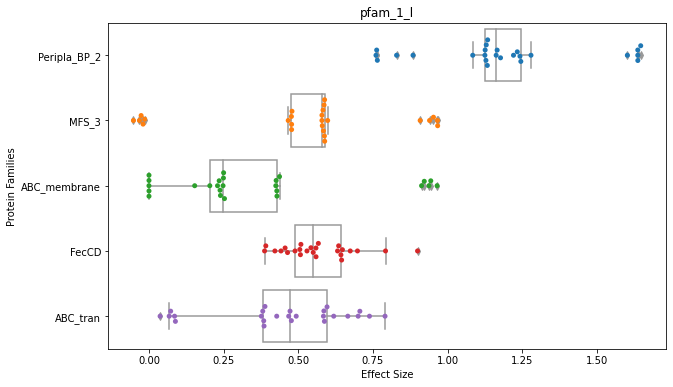

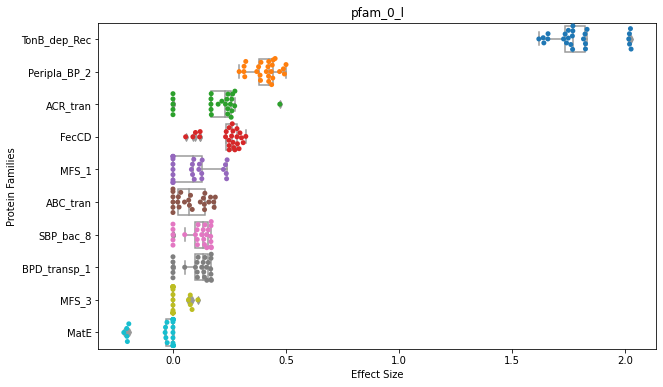

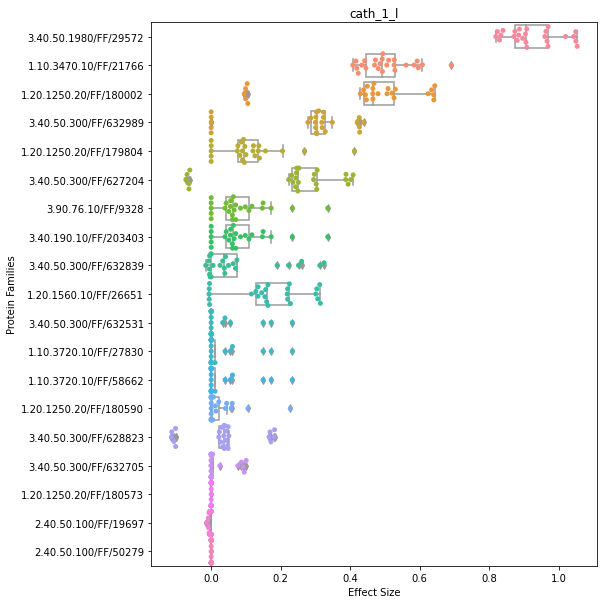

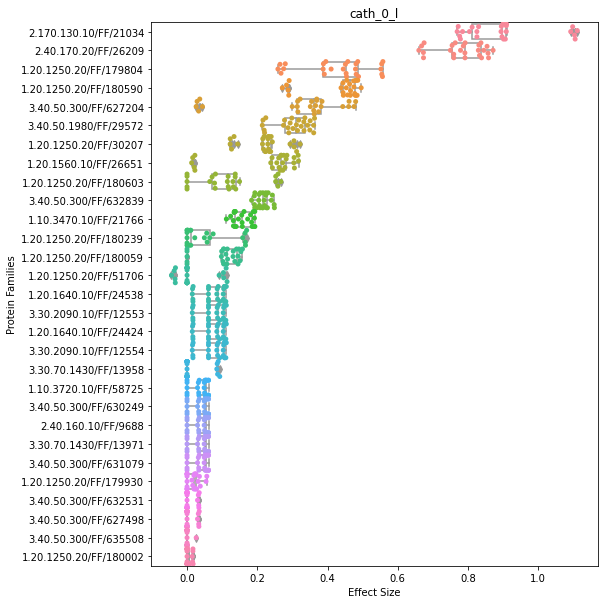

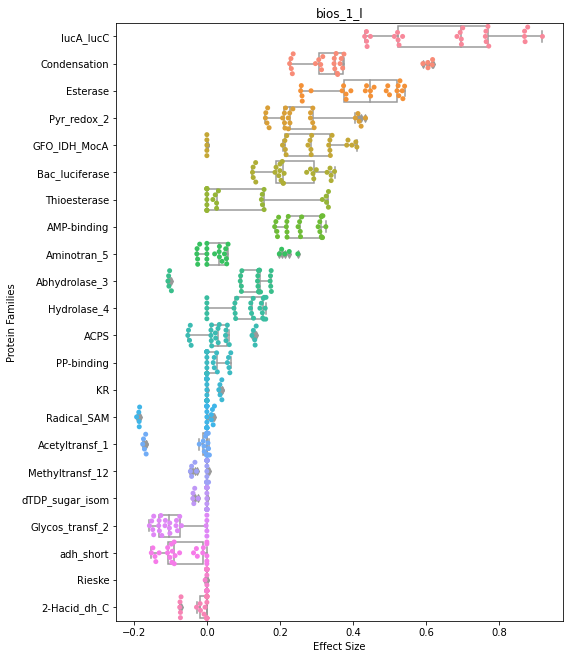

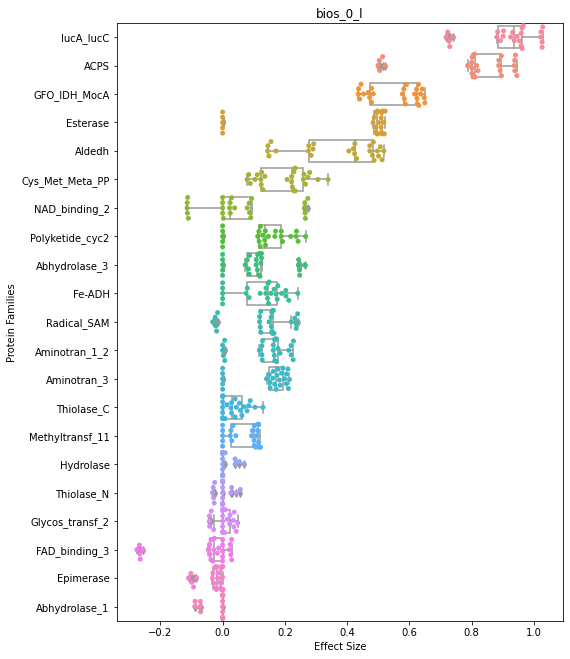

In [413]:
plot_features(results['pfam_1_l']['features'], 'pfam_1_l', (10,6))
plot_features(results['pfam_0_l']['features'], 'pfam_0_l', (10,6))
plot_features(results['cath_1_l']['features'], 'cath_1_l', (8,10))
plot_features(results['cath_0_l']['features'], 'cath_0_l', (8,10))
plot_features(results['bios_1_l']['features'], 'bios_1_l', (8,11))
plot_features(results['bios_0_l']['features'], 'bios_0_l', (8,11))

# Predict siderophores in unlabeled data

In [43]:
unknowns = mibig_metadata.query("~Structure.isnull() & Activities.isnull() & Antibacterial == 0 & Antifungal == 0 & Siderophore == 0")

unknown_data = sbp_all_pfam[sbp_all_pfam.BGC.isin(unknowns['BGC'])]

In [216]:
unknowns[unknowns.BGC.isin(unknown_data.query("Peripla_BP_2 > 0")['BGC'])]

,BGC,Genus,Name,Compound_count,MW,TPSA,LOGP,HACC,HDON,Type,Activities,Structure,Gram,Antibacterial,Antifungal,Siderophore,Orf_length,label
336,BGC0000371,Rhodococcus,heterobactin a,2,615.228890,276.24,-1.25510,10.0,10.0,NRP,NaN,NC(NCCC[C@@H](NC(=O)C1=C(O)C(O)=CC=C1)C(=O)NCC...,1,0,0,0,11,-1
845,BGC0000699,Streptomyces,hygromycin a,1,511.168975,204.47,-2.46740,12.0,7.0,Saccharide,NaN,CC(=O)[C@H]1O[C@@H](OC2=C(O)C=C(\C=C(/C)C(=O)N...,1,0,0,0,33,-1
854,BGC0001593,Streptomyces,ficellomycin,1,312.190989,159.83,-2.36240,5.0,5.0,NRP,NaN,CC(C)C(C(=O)NC(C1CC(C2N1C2)N=C(N)N)C(=O)O)N,1,0,0,0,55,-1
1015,BGC0000366,Streptomyces,gobichelin a,2,671.302724,273.69,-2.42450,12.0,9.0,NRP,NaN,C1C[C@@H](C(=O)N(C1)O)NC(=O)[C@H](CO)NC(=O)[C@...,1,0,0,0,18,-1
1163,BGC0001195,Nocardiopsis,nocardiopsin a,4,573.366553,110.21,5.25500,7.0,1.0,NRP,NaN,CCC(=O)CC(C1(CC(C2CCC(O2)CC/C=C(\C(=O)C(CC/C=C...,1,0,0,0,19,-1
1318,BGC0000708,Streptomyces,lividomycin,1,761.354210,406.24,-10.00830,23.0,15.0,Saccharide,NaN,C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C...,1,0,0,0,30,-1
1630,BGC0000368,Streptomyces,streptobactin,1,1179.494500,560.58,-3.33129,21.0,21.0,NRP,NaN,C[C@H]1OC(=O)[C@@H](NC(=O)[C@H](CCCNC(N)=N)NC(...,1,0,0,0,17,-1
1708,BGC0000074,Streptomyces,herbimycin a,1,574.289031,152.48,2.71330,9.0,2.0,Polyketide,NaN,CO[C@H]1C[C@H](C)[C@@H](OC)C2=CC(=O)C=C(NC(=O)...,1,0,0,0,30,-1
1796,BGC0000940,Streptomyces,desferrioxamin b,2,560.353362,205.84,0.92210,9.0,6.0,Other,NaN,CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC...,1,0,0,0,6,-1


In [46]:
# heterobactin a = siderophore
# ficellomycin = antibiotic
# hygromycin a = NOT SIDEROPHORE
# gobichelin a = siderophore
# streptobactin = siderophore
# lividomycin = antibiotic
# herbimycin a = kinda weird inhibitor that can be both antibiotic and herbicidal\
# desferrioxamin b = siderophore

336    heterobactin a
Name: Name, dtype: object
845    hygromycin a
Name: Name, dtype: object
854    ficellomycin
Name: Name, dtype: object
1015    gobichelin a
Name: Name, dtype: object
1163    nocardiopsin a
Name: Name, dtype: object
1318    lividomycin
Name: Name, dtype: object
1630    streptobactin
Name: Name, dtype: object
1708    herbimycin a
Name: Name, dtype: object
1796    desferrioxamin b
Name: Name, dtype: object


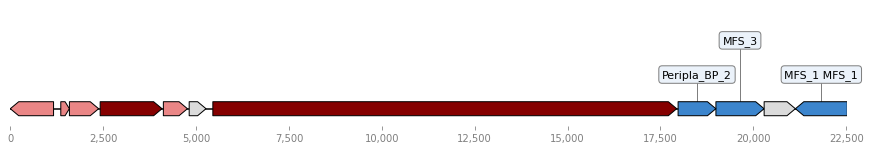

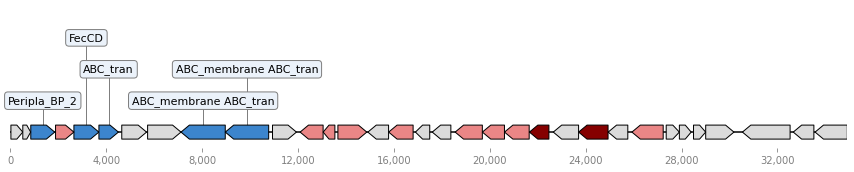

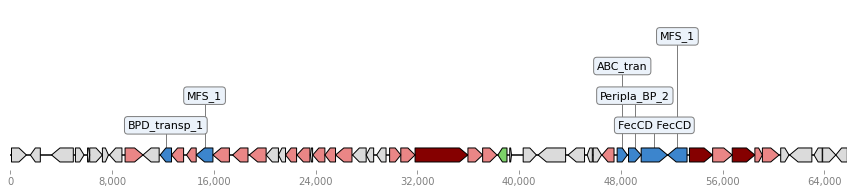

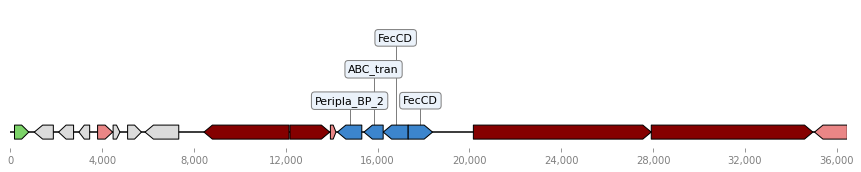

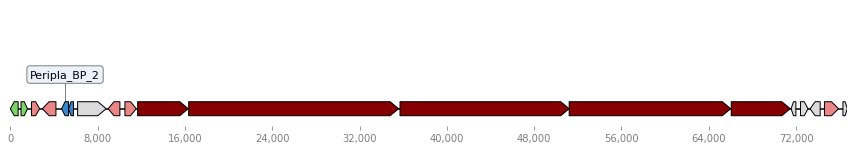

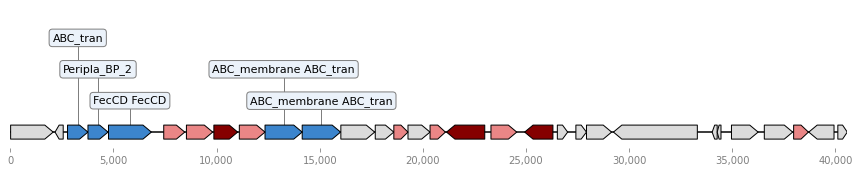

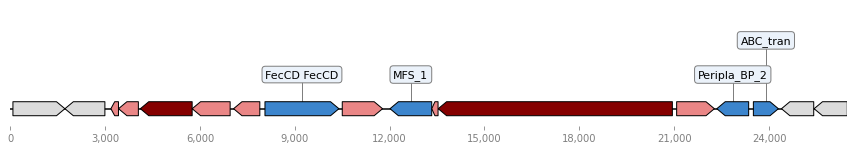

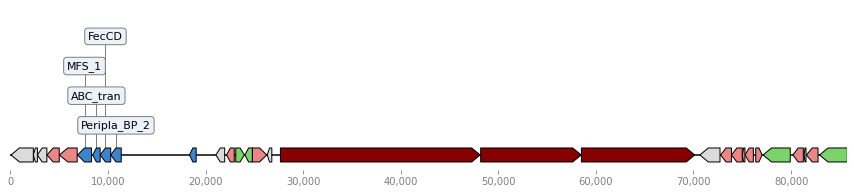

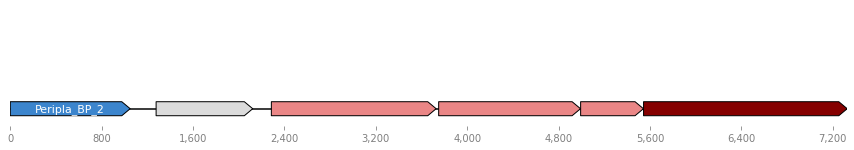

In [222]:
from plot_mibig import mibig_viewer
for BGC in unknowns[unknowns.BGC.isin(unknown_data.query("Peripla_BP_2 > 0")['BGC'])]['BGC']:
    print(unknowns[unknowns.BGC.isin([BGC])]['Name'])
    mibig_viewer('/groups/banfield/users/alexcc/song_collaboration/mibig_db2/mibig_gbk_2.0/', #1st is directory of downloaded mibig GBKs
                 '/groups/banfield/users/alexcc/song_collaboration/bgc_tran/data/raw/mibig_all_pfams.txt', #2nd is the new file in raw data
                 BGC, 
                 BGC + '.svg') #3rd is BGC name
#                  #4th argument can be a list of transporter PFAMs you want to label

1708    herbimycin a
Name: Name, dtype: object